     |████████████████████████████████| 11.8MB 4.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617579 sha256=4a025fb4765bdddf0bd174c0416008e74f65b91ea8d7d3ec0d3e55a461be9c02
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
import warnings; warnings.simplefilter('ignore')

In [6]:
mdf = pd. read_csv('/content/movies_metadata.csv')
mdf.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
!pip install scikit-surprise

In [7]:
mdf['genres'] = mdf['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [9]:
vote_counts = mdf[mdf['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = mdf[mdf['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [10]:
min_req = vote_counts.quantile(0.95)
min_req

434.0

In [12]:
mdf['year'] = pd.to_datetime(mdf['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [14]:
qlfd_mov = mdf[(mdf['vote_count'] >= min_req ) & (mdf['vote_count'].notnull()) & (mdf['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qlfd_mov['vote_count'] = qlfd_mov['vote_count'].astype('int')
qlfd_mov['vote_average'] = qlfd_mov['vote_average'].astype('int')
qlfd_mov.shape

(2274, 6)

In [15]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+min_req) * R) + (min_req/(min_req+v) * C)

In [16]:
qlfd_mov['wr'] = qlfd_mov.apply(weighted_rating, axis=1)

In [17]:
qlfd_mov = qlfd_mov.sort_values('wr', ascending=False).head(250)

In [18]:
qlfd_mov.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.851924


In [20]:
schart = mdf.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
schart.name = 'genre'
gen_mdf = mdf.drop('genres', axis=1).join(schart)

In [21]:
def build_chart(genre, percentile=0.85):
    df = gen_mdf[gen_mdf['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qlfd = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qlfd['vote_count'] = qlfd['vote_count'].astype('int')
    qlfd['vote_average'] = qlfd['vote_average'].astype('int')
    
    qlfd['wr'] = qlfd.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qlfd = qlfd.sort_values('wr', ascending=False).head(250)
    
    return qlfd

In [22]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457,8.565285
351,Forrest Gump,1994,8147,8,48.3072,7.971357
876,Vertigo,1958,1162,8,18.2082,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.8451,7.745154
1132,Cinema Paradiso,1988,834,8,14.177,7.744878
19901,Paperman,2012,734,8,7.19863,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.9943,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


In [23]:
links_small = pd.read_csv('/content/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [24]:
mdf = mdf.drop([19730, 29503, 35587])

In [25]:
mdf['id'] = mdf['id'].astype('int')

In [26]:
smd = mdf[mdf['id'].isin(links_small)]
smd.shape

(9099, 25)

In [27]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [28]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [29]:
tfidf_matrix.shape

(9099, 268124)

In [30]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [31]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [32]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [33]:
def recomend_movie(title):
    idx = indices[title]
    mov_similarity_scr = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [34]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [104]:
get_recommendations('The Godfather: Part III').head(10)

973        The Godfather: Part II
5294             Infernal Affairs
2624               Bad Lieutenant
692                 The Godfather
5631                   I Am David
4579     The Lizzie McGuire Movie
5393    The Chronicles of Riddick
5314                 Mean Streets
8768                         Cake
2909                        Lured
Name: title, dtype: object

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

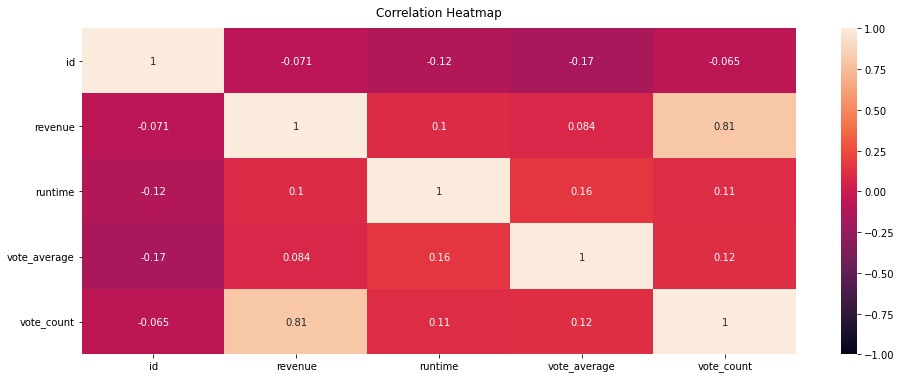

In [88]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(mdf.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [89]:
mdf.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'year'],
      dtype='object')

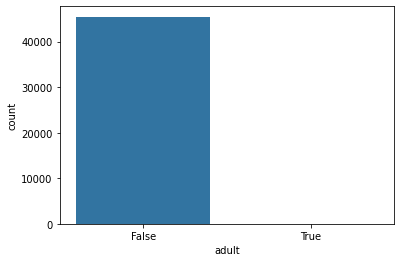

In [92]:
sns.countplot(x ='adult', data = mdf)
 
# Show the plot
plt.show()

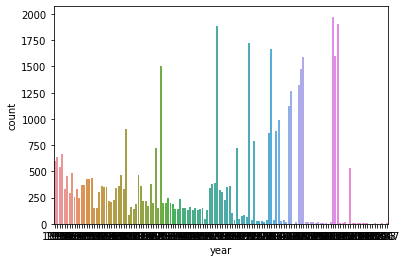

In [93]:
sns.countplot(x ='year', data = mdf)
 
# Show the plot
plt.show()

original_language  year
ab                 1969     1
                   1986     1
                   2002     1
                   2004     1
                   2007     1
                           ..
zh                 2015    30
                   2016    18
                   2017     8
                   NaT      1
zu                 2004     1
Name: status, Length: 2072, dtype: int64


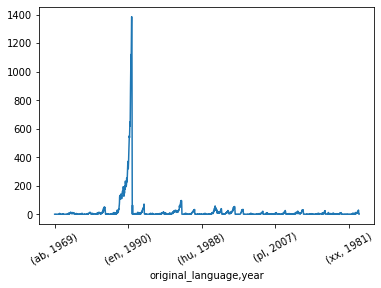

In [99]:
df = mdf.groupby(['original_language', 'year']).count()['status']
print(df) 
  
# plot the result 
df.plot() 
plt.xticks(rotation=30) 
plt.show() 

In [103]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
plt.figure(figsize=(15,10))
country.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Country of Origin")
plt.ylabel("Number of Wines")
plt.show()